In [ ]:
!nvidia-smi

Wed Feb  7 17:11:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install Required Libraries**

In [ ]:
!pip install --quiet pytorch_lightning
!pip install --quiet  transformers
!pip install --quiet  seaborn
!pip install --quiet  wget

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


# **Import Required Libraries**

In [ ]:
import pytorch_lightning as pl
import json
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from termcolor import colored
import textwrap

from transformers import AdamW, T5ForConditionalGeneration, T5TokenizerFast as T5Tokenizer
from tqdm.auto import tqdm

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

sns.set(style='whitegrid',palette='muted',font_scale=1.2)
rcParams['figure.figsize'] = 16, 6

In [ ]:
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

#**Loading the Dataset**

In [ ]:
url = 'news_summary.csv'

In [ ]:
df = pd.read_csv(url,encoding='latin')

In [ ]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

In [ ]:
df = df[["text","ctext"]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
df.columns

Index(['author', 'date', 'headlines', 'read_more', 'text', 'ctext'], dtype='object')

# **Overview of the Dataset**

In [ ]:
df.columns = ["author", "ctext", "date", "location", "summary", "text"]
df = df.dropna()
df.head()

,author,ctext,date,location,summary,text
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [ ]:
df.shape

(4396, 6)

# **Train Test Split of the Data**

In [ ]:
train_df, test_df = train_test_split(df,test_size=0.1)
train_df.shape,test_df.shape

((3956, 6), (440, 6))

# **Tokenize and Process the Data for Model**

In [ ]:
class NewsSummaryDataset(Dataset):
    def __init__(
      self,
      data : pd.DataFrame,
      tokennizer : T5Tokenizer,
      text_max_token_len : 512,
      summary_max_token_len : 128):

      self.tokennizer = tokennizer
      self.data = data,
      self.text_max_token_len = text_max_token_len
      self.summary_max_token_len = summary_max_token_len

    def __len__(self):
      return len(self.data)

    def __getitem__(self, index : int):
      data_row = self.data[0].iloc[index]
      text = data_row["text"]

      text_encoding = self.tokennizer(
          text,
          max_length = self.text_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"
      )

      summary_encoding = self.tokennizer(
          data_row["summary"],
          max_length = self.summary_max_token_len,
          padding = "max_length",
          truncation = True,
          return_attention_mask = True,
          return_tensors = "pt"   # Return PyTorch tensors
      )

      labels = summary_encoding["input_ids"]
      labels[labels==0] = -100

      return dict(
          text = text,
          summary = data_row["summary"],
          text_input_ids = text_encoding["input_ids"].flatten(),
          text_attention_mask = text_encoding["attention_mask"].flatten(),
          labels = labels.flatten(),
          labels_attention_mask = summary_encoding["attention_mask"].flatten()
      )


# **Dataset Preparation Module Using DataLoader**

In [ ]:
class NewsSummaryDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df : pd.DataFrame,
        test_df : pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size : int  = 8,
        text_max_token_len : int = 512,
        summary_max_token_len :int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    # LightningModule.setup(stage=None)
    # Called at the beginning of fit (train + validate), validate, test, or predict.

    def setup(self, stage=None):

        self.train_dataset = NewsSummaryDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

        self.test_dataset = NewsSummaryDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.summary_max_token_len)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle= True,
            num_workers=2
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle= False,
            num_workers=2
        )

# **Importing the Tokennizer corresponding to T5-Base**

In [ ]:
MODEL_NAME = "t5-base"

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


#**Distribution of Sentence len : News vs Summary**

In [ ]:
text_token_counts = []
summary_token_counts = []

for _, row in train_df.iterrows():

    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)

    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)


Token indices sequence length is longer than the specified maximum sequence length for this model (663 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'Summary text token counts')

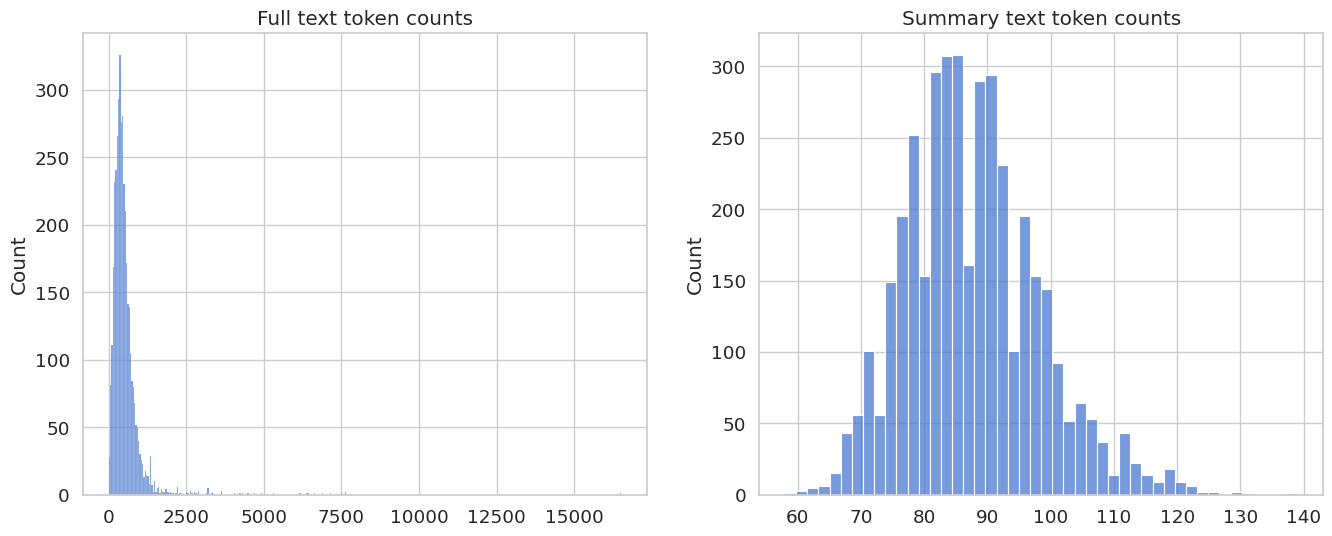

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.histplot(text_token_counts,ax=ax1)
ax1.set_title("Full text token counts")

sns.histplot(summary_token_counts,ax=ax2)
ax2.set_title("Summary text token counts")


# **Data Module using DataLoader and Preprocess for training**

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 16

data_module = NewsSummaryDataModule(train_df,test_df,tokenizer,batch_size=BATCH_SIZE)

# **Model Architecture**

In [ ]:
class NewsSummaryModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME,return_dict=True)

    def forward(self,input_ids,attention_mask,decoder_attention_mask, labels=None):

        output = self.model(
            input_ids,
            attention_mask = attention_mask,
            labels = labels,
            decoder_attention_mask = decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("train_loss",loss,prog_bar=True,logger=True)

        return loss


    def validation_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("val_loss",loss,prog_bar=True,logger=True)

        return loss

    def test_step(self, batch, batch_idx):

        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids = input_ids,
            attention_mask = attention_mask,
            decoder_attention_mask = labels_attention_mask,
            labels = labels
        )

        self.log("test_loss",loss,prog_bar=True,logger=True)

        return loss


    def configure_optimizers(self):
        return AdamW(self.parameters(),lr = 0.0001)

In [ ]:
model = NewsSummaryModel()

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
##%load_ext tensorboard
##%tensorboard --logdir ./lightning_logs

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_loss",name="news-summary")



trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator="auto",
    enable_progress_bar=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# **Training**

In [ ]:
trainer.fit(model,datamodule = data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 1: 'val_loss' reached 2.08473 (best 2.08473), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 2: 'val_loss' reached 2.07808 (best 2.07808), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 3: 'val_loss' reached 2.07334 (best 2.07334), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 4: 'val_loss' reached 2.07113 (best 2.07113), saving model to '/content/checkpoints/best-checkpoint.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 5: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 6: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 7: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 9: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 10: 'val_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# **Using the Model for Inference**

In [ ]:
trained_model = NewsSummaryModel.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

trained_model.freeze()

# **Function to Predict Summary**

In [ ]:
def summarize_text(text):
    device = trained_model.device  # Get the device of the trained model

    text_encoding = tokenizer(
        text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # Move input tensors to the same device as the trained model
    text_encoding = {key: value.to(device) for key, value in text_encoding.items()}

    generated_ids = trained_model.model.generate(
        input_ids=text_encoding["input_ids"],
        attention_mask=text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )

    # Move generated_ids back to CPU if it was on GPU
    generated_ids = generated_ids.cpu() if device.type == 'cuda' else generated_ids

    preds = [tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
             for gen_id in generated_ids]

    return " ".join(preds)



# **Prediction on Test Data**

In [ ]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize_text(text)

In [ ]:
text

' Doctors of the Re1 clinic helped a woman from Titwala deliver a child at Ghatkopar railway station on Tuesday. The woman was travelling from Titwala to Dadar in a local train when she went into labour.The successful delivery was carried out by the Re1 clinic team ? Dr Rahul Ghule and Dr Sarita.The girl weighs 2.5kg. The mother was later shifted to Rajawadi hospital for further treatment.Read more: This doctor?s clinic at a Mumbai railway station charges Re1 as fee, treats hundreds in 48 hoursThese clinics are functional at Dadar, Kurla, Ghatkopar, Mankhurd and Wadala stations on the Central Railway?s suburban line. They started on May 20 and have treated 12,555 patients so far. ?Every day we deal with eight to 10 emergencies , which need investigations such as MRIs and X-Rays. Around 50 to 60 patients undergo treatment and blood tests for general diagnosis,? Dr Ghule said.Accident victims at railway stations prefer these clinics to the medical attendants of Emergency 108 Ambulances a

In [ ]:
model_summary

'doctors of the Re1 clinic helped a woman from Titwala deliver a child at Ghatkopar railway station on Tuesday. the successful delivery was carried out by the doctor team? Dr Rahul Ghule and Dr Sarita.'

In [ ]:

sample_row["summary"]

'The doctors from ?1 clinic at Ghatkopar railway station in Mumbai helped a woman deliver her child on Tuesday. The woman was travelling to Dadar when she went into labour and the clinic doctors rushed to her help immediately. These clinics were started on May 20 across 14 Mumbai railway stations, and have treated more than 12,000 patients so far.'

# **Prediction On Random News**

# *Vedanta's chairman Anil Agarwal earlier this week announced the biggest investment of ₹1.54 lakh crore for setting up the country's first-ever semiconductor chip plant in Gujarat. This led to a strong buying on stock exchanges that drove Vedanta to rise nearly 18% this week. However, on the last trading day of the current week, Vedanta shares pulled back and slipped by at least nearly 9% on BSE after the company said, the semiconductor plant project is not under their ambit but will be undertaken by Volcan Investments.On Thursday, in its regulatory filing, Vedanta said, " we reiterate that the proposed business of manufacturing semiconductors is not under Vedanta and we understand that it will be undertaken by the ultimate holding company of Vedanta, Volcan Investments."This week, in a statement, Vedanta said the company signed two Memorandum of Understanding (MoUs) with the Gujarat government to set up a semiconductor fab unit, a display fab unit, and a semiconductor assembling and testing unit in the Ahmedabad district of the state.*

In [38]:
text = "Gujarat Congress MLAs lodged in a Karnataka resort to deter defections from their ranks ahead of next week?s Rajya Sabha polls say the south Indian food being served to them is a big sore point amid their four-star comfort.?All the arrangements are great. But there is bound to be a difference in cuisine,? Gyasuddin Shaikh, one of the 42 legislators, told Hindustan Times on Tuesday. ?We Gujaratis have food that is not very spicy. We like roti, dal and kadhi, so there is a change,? he regretted.Reluctant to leave anything to chance before the August 8 vote which has senior Congress leader Ahmed Patel vying for one of the three Rajya Sabha seats from Gujarat, the party leadership has decided to arrange for a Gujarati chef for the legislators? culinary comfort.DK Shivakumar, the power minister in Karnataka?s Congress government, said a Gujarati chef will be made available for the MLAs soon. ?Some have even expressed the desire to cook and asked the resort for permission, which has been granted,? he added. A nostalgic Shaikh said a typical breakfast back home in Gujarat consisted of ?bhakhri? and ?thepla?. Lunch normally consisted of dal, roti and a dry vegetable dish.However, breakfast at ?Eagleton - The Golf Village?, some 40km outside the state capital Bengaluru, typically comprised idli and dosa while the menu for lunch mostly included rice or ragi balls.?In Gujarat, we are not used to consuming much rice. We prefer roti,? Shaikh explained.The Congress legislators were flown to Bengaluru late on Friday after six of their colleagues quit the party, depleting its numerical strength in the Gujarat assembly to 51.At least half-a-dozen of the remaining legislators are reportedly loyalists of Shankersinh Vaghela, a former chief minister recently expelled from the party. Patel needs the support of 45 MLAs to be re-elected and the Congress is doing everything it can to keep its flock together.On Saturday, the Congress moved the chief election commissioner, accusing the BJP government of Gujarat of using ?money, muscle power and government machinery? to engineer defections. The BJP has denied all the charges."

In [41]:
summarize_text(text)

'?we like roti, dal and kadhi, so there is a change,? said one of the legislators.The resort in Karnataka has been granted permission for a Gujarati chef.'

## evaluating the model's performance

In [ ]:
!pip install nltk

In [36]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu

reference_summaries = test_df["summary"].tolist()  # Ground truth summaries
generated_summaries = [summarize_text(text) for text in test_df["text"]]

# Compute ROUGE scores
rouge_scores = corpus_bleu(reference_summaries, generated_summaries)
print("ROUGE Score:", rouge_scores)


ROUGE Score: 1.0522151533327512e-231
